# Kaggle dataset on restraunt from Zomato 
### Dataset details
### Problem statement
    Predicting the rating of the restraunt based on the givern features

#### PROGRESS
    1.removing the totally useless columns, url
    2.removing the name but its count is approx. 17%, so NO because it could bee a key factor
    3.address could be a key factor as well, because it plays as the reputation factor of a restraunt, we have an easy option location column, so removing address as well
    4.phone, same as url, doesn't matter with respect to ratings
    5.dish_liked, 50% missing, and we can't impute such things as it totally depends on peoples view, and even if we impute that will add 50% chance of reduntant info which ultimately distrupt the model performance, so imputing or dropping this column would be the same, but it would be best to drop as this feature is totally influenced by peoples
    6.menu_item is also the same as dish_liked having no missing, but empty lists
    7. I can imputing the rate with help of reviews_list 7775 total missings, but its an indiividual view not mean so can't use that either.
    8. columns correction, for easy handling of columns later,
    9. missing vals imputation
    10. check for feature scaling, using xgb so scaling is not necessary
    11. feature selection with threshold variance, using all features, no significant co-relation between features
    12. model building, XGBregressor does really well
    13. building a pipeline for preprocessing and training model for streamlit application.
    

### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split as tts, GridSearchCV, RandomizedSearchCV, cross_val_score

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR, LinearSVR,NuSVR

from sklearn.ensemble import ExtraTreesRegressor

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix,mean_absolute_error as mae, r2_score as r2
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler,RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from imblearn.over_sampling import ADASYN,SMOTE


import warnings
from time import time
warnings.filterwarnings('ignore')

### Reading dataset and general exploration

In [2]:
df = pd.read_csv('zomato.csv')


In [3]:
df.head()

,url,address,name,online_order,book_table,rate,votes,phone,location,rest_type,dish_liked,cuisines,approx_cost(for two people),reviews_list,menu_item,listed_in(type),listed_in(city)
0,https://www.zomato.com/bangalore/jalsa-banasha...,"942, 21st Main Road, 2nd Stage, Banashankari, ...",Jalsa,Yes,Yes,4.1/5,775,080 42297555\r\n+91 9743772233,Banashankari,Casual Dining,"Pasta, Lunch Buffet, Masala Papad, Paneer Laja...","North Indian, Mughlai, Chinese",800,"[('Rated 4.0', 'RATED\n A beautiful place to ...",[],Buffet,Banashankari
1,https://www.zomato.com/bangalore/spice-elephan...,"2nd Floor, 80 Feet Road, Near Big Bazaar, 6th ...",Spice Elephant,Yes,No,4.1/5,787,080 41714161,Banashankari,Casual Dining,"Momos, Lunch Buffet, Chocolate Nirvana, Thai G...","Chinese, North Indian, Thai",800,"[('Rated 4.0', 'RATED\n Had been here for din...",[],Buffet,Banashankari
2,https://www.zomato.com/SanchurroBangalore?cont...,"1112, Next to KIMS Medical College, 17th Cross...",San Churro Cafe,Yes,No,3.8/5,918,+91 9663487993,Banashankari,"Cafe, Casual Dining","Churros, Cannelloni, Minestrone Soup, Hot Choc...","Cafe, Mexican, Italian",800,"[('Rated 3.0', ""RATED\n Ambience is not that ...",[],Buffet,Banashankari
3,https://www.zomato.com/bangalore/addhuri-udupi...,"1st Floor, Annakuteera, 3rd Stage, Banashankar...",Addhuri Udupi Bhojana,No,No,3.7/5,88,+91 9620009302,Banashankari,Quick Bites,Masala Dosa,"South Indian, North Indian",300,"[('Rated 4.0', ""RATED\n Great food and proper...",[],Buffet,Banashankari
4,https://www.zomato.com/bangalore/grand-village...,"10, 3rd Floor, Lakshmi Associates, Gandhi Baza...",Grand Village,No,No,3.8/5,166,+91 8026612447\r\n+91 9901210005,Basavanagudi,Casual Dining,"Panipuri, Gol Gappe","North Indian, Rajasthani",600,"[('Rated 4.0', 'RATED\n Very good restaurant ...",[],Buffet,Banashankari


In [4]:
len(df)

51717

In [5]:
df.columns

Index(['url', 'address', 'name', 'online_order', 'book_table', 'rate', 'votes',
       'phone', 'location', 'rest_type', 'dish_liked', 'cuisines',
       'approx_cost(for two people)', 'reviews_list', 'menu_item',
       'listed_in(type)', 'listed_in(city)'],
      dtype='object')

### Uniqueness/Missing summary

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51717 entries, 0 to 51716
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   url                          51717 non-null  object
 1   address                      51717 non-null  object
 2   name                         51717 non-null  object
 3   online_order                 51717 non-null  object
 4   book_table                   51717 non-null  object
 5   rate                         43942 non-null  object
 6   votes                        51717 non-null  int64 
 7   phone                        50509 non-null  object
 8   location                     51696 non-null  object
 9   rest_type                    51490 non-null  object
 10  dish_liked                   23639 non-null  object
 11  cuisines                     51672 non-null  object
 12  approx_cost(for two people)  51371 non-null  object
 13  reviews_list                 51

In [7]:
df.rename(columns={'approx_cost(for two people)':'price','listed_in(type)':'type','listed_in(city)':'city'},inplace=True)

In [8]:
dist = df.apply(lambda x:[x.nunique(), round(x.nunique()/len(df),4),round(x.isna().sum(),4),round(x.isna().sum()/len(df),4)])
print('Percentage wise distribution of unique values')
x = dist.transpose()
x= x.rename(columns={0:'Count of Unique',1:'Percentage of Unqiue',2:'Count of Missing',3:'Percentage of Missing'})
x

Percentage wise distribution of unique values


,Count of Unique,Percentage of Unqiue,Count of Missing,Percentage of Missing
url,51717.0,1.0000,0.0,0.0000
address,11495.0,0.2223,0.0,0.0000
name,8792.0,0.1700,0.0,0.0000
online_order,2.0,0.0000,0.0,0.0000
book_table,2.0,0.0000,0.0,0.0000
rate,64.0,0.0012,7775.0,0.1503
votes,2328.0,0.0450,0.0,0.0000
phone,14926.0,0.2886,1208.0,0.0234
location,93.0,0.0018,21.0,0.0004
rest_type,93.0,0.0018,227.0,0.0044


In [9]:
df.describe()

,votes
count,51717.000000
mean,283.697527
std,803.838853
min,0.000000
25%,7.000000
50%,41.000000
75%,198.000000
max,16832.000000


### Data Cleaning

#### Dropping the non-essential, redundant columns

In [10]:
df.drop(columns=['url','address','phone','dish_liked', 'menu_item','reviews_list'],axis=1,inplace=True)

In [11]:
df.iloc[0]

name                                     Jalsa
online_order                               Yes
book_table                                 Yes
rate                                     4.1/5
votes                                      775
location                          Banashankari
rest_type                        Casual Dining
cuisines        North Indian, Mughlai, Chinese
price                                      800
type                                    Buffet
city                              Banashankari
Name: 0, dtype: object

#### Imputing the rate column with the help of reviews_list

In [12]:
#before imputing 7775
df.rate.isna().sum()

7775

##### removing the /5 from the rate

In [13]:
df.rate= df.rate.apply(lambda x:x.replace('/5','') if type(x) is np.str else x)
df.rate = df.rate.apply(lambda x:x.replace('NEW','') if type(x) is np.str else x)
df.rate = df.rate.apply(lambda x:x.replace('-','') if type(x) is np.str else x)

In [14]:
df.rate.unique()

array(['4.1', '3.8', '3.7', '3.6', '4.6', '4.0', '4.2', '3.9', '3.1',
       '3.0', '3.2', '3.3', '2.8', '4.4', '4.3', '', '2.9', '3.5', nan,
       '2.6', '3.8 ', '3.4', '4.5', '2.5', '2.7', '4.7', '2.4', '2.2',
       '2.3', '3.4 ', '3.6 ', '4.8', '3.9 ', '4.2 ', '4.0 ', '4.1 ',
       '3.7 ', '3.1 ', '2.9 ', '3.3 ', '2.8 ', '3.5 ', '2.7 ', '2.5 ',
       '3.2 ', '2.6 ', '4.5 ', '4.3 ', '4.4 ', '4.9', '2.1', '2.0', '1.8',
       '4.6 ', '4.9 ', '3.0 ', '4.8 ', '2.3 ', '4.7 ', '2.4 ', '2.1 ',
       '2.2 ', '2.0 ', '1.8 '], dtype=object)

##### Converting strings to numeric

In [15]:
df.rate = pd.to_numeric(df.rate)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51717 entries, 0 to 51716
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          51717 non-null  object 
 1   online_order  51717 non-null  object 
 2   book_table    51717 non-null  object 
 3   rate          41665 non-null  float64
 4   votes         51717 non-null  int64  
 5   location      51696 non-null  object 
 6   rest_type     51490 non-null  object 
 7   cuisines      51672 non-null  object 
 8   price         51371 non-null  object 
 9   type          51717 non-null  object 
 10  city          51717 non-null  object 
dtypes: float64(1), int64(1), object(9)
memory usage: 4.3+ MB


In [17]:
df.online_order = df.online_order.replace(('Yes','No'),(1,0))
df.book_table = df.book_table.replace(('Yes','No'),(1,0))

In [18]:
df.rename(columns={'approx_cost(for two people)':'price','listed_in(type)':'type','listed_in(city)':'city'},inplace=True)

In [19]:
df.price = df.price.astype(str)
df.price=df.price.apply(lambda x:x.replace(',',''))
df.price = df.price.astype(float)

In [20]:
df.head()

,name,online_order,book_table,rate,votes,location,rest_type,cuisines,price,type,city
0,Jalsa,1,1,4.1,775,Banashankari,Casual Dining,"North Indian, Mughlai, Chinese",800.0,Buffet,Banashankari
1,Spice Elephant,1,0,4.1,787,Banashankari,Casual Dining,"Chinese, North Indian, Thai",800.0,Buffet,Banashankari
2,San Churro Cafe,1,0,3.8,918,Banashankari,"Cafe, Casual Dining","Cafe, Mexican, Italian",800.0,Buffet,Banashankari
3,Addhuri Udupi Bhojana,0,0,3.7,88,Banashankari,Quick Bites,"South Indian, North Indian",300.0,Buffet,Banashankari
4,Grand Village,0,0,3.8,166,Basavanagudi,Casual Dining,"North Indian, Rajasthani",600.0,Buffet,Banashankari


#### Imputing the missing values

In [21]:
def percentage_summary(df):
    dist = df.apply(lambda x:[x.nunique(), round(x.nunique()/len(df),4),round(x.isna().sum(),4),round(x.isna().sum()/len(df),4)])
    x = dist.transpose()
    x= x.rename(columns={0:'Count of Unique',1:'Percentage of Unqiue',2:'Count of Missing',3:'Percentage of Missing'})
    return x

In [22]:
percentage_summary(df)

,Count of Unique,Percentage of Unqiue,Count of Missing,Percentage of Missing
name,8792.0,0.1700,0.0,0.0000
online_order,2.0,0.0000,0.0,0.0000
book_table,2.0,0.0000,0.0,0.0000
rate,31.0,0.0006,10052.0,0.1944
votes,2328.0,0.0450,0.0,0.0000
location,93.0,0.0018,21.0,0.0004
rest_type,93.0,0.0018,227.0,0.0044
cuisines,2723.0,0.0527,45.0,0.0009
price,70.0,0.0014,346.0,0.0067
type,7.0,0.0001,0.0,0.0000


##### as per my knowledge its not good idea to impute the target values so jump to the pipelines for next step
##### approach 1 (dropping the target - rate)


In [23]:
df.shape

(51717, 11)

In [24]:
df1 = df.copy()
df1 = df1.dropna()
df1.drop_duplicates(inplace=True)
df1.shape

(41190, 11)

dropping rest_type, cuisines, price with rate

rest_type and cuisines, having approx 0.004% of missing
Assuming : So imputing them (at the most ideal case) will have a chance of improvement in our model is 0.004% (max. where we got all our values correct as true values)
so either impute them or not it won't be that effective, 

while price is having 0.006% of missing
and that could be explored further with regression or other techniques but leaving it for now,

In [25]:
percentage_summary(df1)

,Count of Unique,Percentage of Unqiue,Count of Missing,Percentage of Missing
name,6602.0,0.1603,0.0,0.0
online_order,2.0,0.0000,0.0,0.0
book_table,2.0,0.0000,0.0,0.0
rate,31.0,0.0008,0.0,0.0
votes,2323.0,0.0564,0.0,0.0
location,92.0,0.0022,0.0,0.0
rest_type,87.0,0.0021,0.0,0.0
cuisines,2367.0,0.0575,0.0,0.0
price,63.0,0.0015,0.0,0.0
type,7.0,0.0002,0.0,0.0


In [26]:
df.name.value_counts()[:10].index

Index(['Cafe Coffee Day', 'Onesta', 'Just Bake', 'Empire Restaurant',
       'Five Star Chicken', 'Kanti Sweets', 'Petoo', 'Polar Bear',
       'Baskin Robbins', 'Chef Baker's'],
      dtype='object')

later : applying regression is a good idea here, because price depends upon various factors of a restraunt like location, type, ratings etc but since the data is quite imbalance of our sub-target(df.price), ik adasyn or smote will do the job, but their synthetic points wouldn't add lots of improvement of the final model so

conclusion : going for a cheap alternative of our good old mean, which is assigned as per their grouped by(df.location and then its type), which would be provide same or better results than regression 

#### Encoding the cat features

In [27]:
all_features = df1.columns

##### getting list of cat and num features

In [28]:
df.rate = pd.to_numeric(df.rate)

In [29]:
cat_cols = [x for x in all_features if df1[all_features][x].dtype == "object"]

num_cols = [x for x in all_features if df1[all_features][x].dtype in ['int64', 'float64']]


In [30]:
cat_cols

['name', 'location', 'rest_type', 'cuisines', 'type', 'city']

In [31]:
num_cols

['online_order', 'book_table', 'rate', 'votes', 'price']

In [32]:
all_features

Index(['name', 'online_order', 'book_table', 'rate', 'votes', 'location',
       'rest_type', 'cuisines', 'price', 'type', 'city'],
      dtype='object')

In [33]:
ord_enc = OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1)
OHE_enc = OneHotEncoder(drop='first',handle_unknown='ignore')

normalizer = MinMaxScaler()
standardizer = StandardScaler()

In [34]:
def Encode(zomato):
    for column in zomato.columns[~zomato.columns.isin(['rating', 'cost', 'votes'])]:
        zomato[column] = zomato[column].factorize()[0]
    return zomato

df2 = Encode(df1.copy())

##### checking the corelation between the features

<AxesSubplot:>

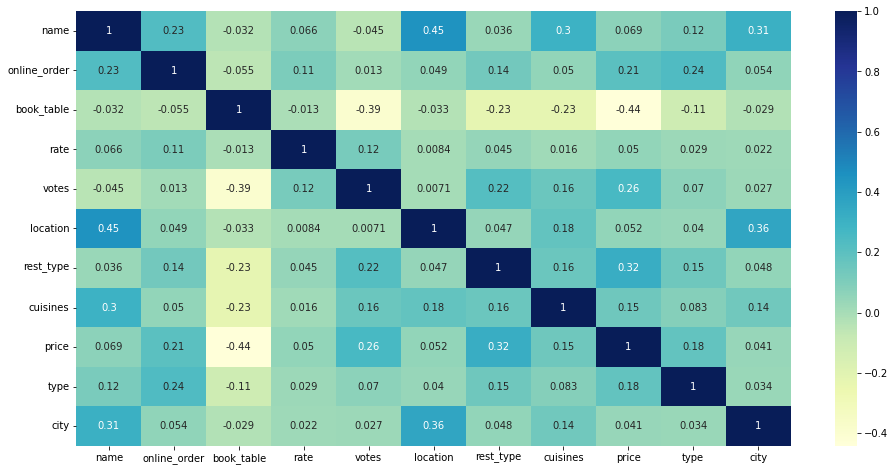

In [35]:
plt.figure(figsize=(16,8))

sns.heatmap(data=df2.corr(),annot=True,cmap='YlGnBu')

### Fitting the best model

In [36]:


X = df2[['name', 'online_order', 'book_table', 'votes', 'location',
       'rest_type', 'cuisines', 'price', 'type', 'city']]
y = df2['rate']

In [37]:
X_train, X_test, y_train, y_test = tts(X,y)

In [38]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((30892, 10), (10298, 10), (30892,), (10298,))

In [39]:
lr = LinearRegression()
rf = RandomForestRegressor(n_estimators=200,random_state=50,min_samples_leaf=.00001)
xgbr = XGBRegressor(booster = 'gbtree', learning_rate = 0.1, max_depth = 15, n_estimators = 200,verbosity=0) #copied
exr = ExtraTreesRegressor(n_estimators=200) # copied from someones notebook

models = [lr,rf,xgbr,exr]

In [40]:
acc = []
total_time = []
for i in models:
    t1= time()
    i.fit(X_train,y_train)
    p = i.predict(X_test)
    t2 = time()
    acc.append(r2(y_test,p))
    total_time.append(t2-t1)


#### both extra tree and xgb performs pretty much the same here is the comparision

In [41]:
comparision = pd.DataFrame({'Models':models,'Accuracy':acc,'Time taken':total_time})
comparision

,Models,Accuracy,Time taken
0,LinearRegression(),0.025717,0.022059
1,"(DecisionTreeRegressor(max_features='auto', mi...",0.854747,23.587694
2,"XGBRegressor(base_score=0.5, booster='gbtree',...",0.872006,7.687440
3,"(ExtraTreeRegressor(random_state=1456384774), ...",0.866498,11.279025


#### XGBoost is our champion for this dataset, with best score, and reasonable time cost

#### Converting this model into pipeline version

In [42]:
df1.apply(lambda x:x.unique())

name            [Jalsa, Spice Elephant, San Churro Cafe, Addhu...
online_order                                               [1, 0]
book_table                                                 [1, 0]
rate            [4.1, 3.8, 3.7, 3.6, 4.6, 4.0, 4.2, 3.9, 3.1, ...
votes           [775, 787, 918, 88, 166, 286, 8, 2556, 324, 50...
location        [Banashankari, Basavanagudi, Mysore Road, Jaya...
rest_type       [Casual Dining, Cafe, Casual Dining, Quick Bit...
cuisines        [North Indian, Mughlai, Chinese, Chinese, Nort...
price           [800.0, 300.0, 600.0, 700.0, 550.0, 500.0, 450...
type            [Buffet, Cafes, Delivery, Desserts, Dine-out, ...
city            [Banashankari, Bannerghatta Road, Basavanagudi...
dtype: object

In [55]:
num_cols.remove('rate')

In [59]:
all_ = num_cols.append(cat_cols)
all_

In [62]:
X = df1[['name', 'online_order', 'book_table', 'votes', 'location',
       'rest_type', 'cuisines', 'price', 'type', 'city']]
y = df1['rate']

ord_transformer = make_column_transformer(
    (ord_enc,cat_cols),
    remainder='passthrough')

OHE_transformer = make_column_transformer((OHE_enc,cat_cols),remainder='passthrough')

X_train, X_test, y_train, y_test = tts(X,y,random_state=28)

pipe = make_pipeline(ord_transformer,xgbr)
pipe.fit(X,y)


ValueError: Specifying the columns using strings is only supported for pandas DataFrames

In [53]:
#ohe encoding
cross_val_score(pipe,X,y,cv=5,n_jobs=-1,).mean()

0.8688450411065016

# Extras

### for model deployement